# **Simple Backtesting with PyCUDA**

* pyCUDA를 이용하여 간단한 백테스팅을 하자. (단기 이동평균선이 장기 이동평균선보다 크면 매수 포지션, 그 외에는 포지션 없음)
* PyCUDA documentation: https://documen.tician.de/pycuda/

# Google Colaboratory에서 pyCUDA를 사용하기 위한 설정

1. 메뉴 > 런타임 > 런타임 유형 변경 > 하드웨어 가속기를 GPU로 변경 > 확인
2. pip로 pyCUDA를 설치

In [ ]:
!pip install pycuda

     |████████████████████████████████| 1.6MB 11.0MB/s 
     |████████████████████████████████| 71kB 10.1MB/s 
     |████████████████████████████████| 81kB 11.2MB/s 
  Created wheel for pycuda: filename=pycuda-2020.1-cp37-cp37m-linux_x86_64.whl size=621490 sha256=c449c22744370eb90c525fff8b0acca77490d1246d6f6c7f2cbd470453061723
  Stored in directory: /root/.cache/pip/wheels/8f/78/d1/5bb826f81d9d490297a348d818ff3ee6dd6f2075b06dde6ea0
  Created wheel for pytools: filename=pytools-2021.2.1-py2.py3-none-any.whl size=62786 sha256=8c7bf8a4fa9b3ef6310d16e57291d2b9d3a2bcc675ae9374066521823b5cf00d
  Stored in directory: /root/.cache/pip/wheels/61/7c/29/7c3f742ab75f8f2df376b72b43e6640167ffbf668c950429bc
Successfully built pycuda pytools


# Block당 할당할 Thread의 개수 정하기

* GPU 속성을 확인해보고, WARP_SIZE를 따로 저장 (WARP_SIZE를 1개의 Block당 할당할 Thread의 개수로 사용)

In [ ]:
import pycuda.autoinit
import pycuda.driver as drv

device = drv.Device(0)
attrs = device.get_attributes()
THD_CNT = attrs.get(drv.device_attribute.WARP_SIZE, 32)

print(f'===== Device Name: {device.name()} =====')

for key, value in attrs.items():
    print("{0} = {1}".format(key, value))

===== Device Name: Tesla T4 =====
ASYNC_ENGINE_COUNT = 3
CAN_MAP_HOST_MEMORY = 1
CLOCK_RATE = 1590000
COMPUTE_CAPABILITY_MAJOR = 7
COMPUTE_CAPABILITY_MINOR = 5
COMPUTE_MODE = DEFAULT
CONCURRENT_KERNELS = 1
ECC_ENABLED = 1
GLOBAL_L1_CACHE_SUPPORTED = 1
GLOBAL_MEMORY_BUS_WIDTH = 256
GPU_OVERLAP = 1
INTEGRATED = 0
KERNEL_EXEC_TIMEOUT = 0
L2_CACHE_SIZE = 4194304
LOCAL_L1_CACHE_SUPPORTED = 1
MANAGED_MEMORY = 1
MAXIMUM_SURFACE1D_LAYERED_LAYERS = 2048
MAXIMUM_SURFACE1D_LAYERED_WIDTH = 32768
MAXIMUM_SURFACE1D_WIDTH = 32768
MAXIMUM_SURFACE2D_HEIGHT = 65536
MAXIMUM_SURFACE2D_LAYERED_HEIGHT = 32768
MAXIMUM_SURFACE2D_LAYERED_LAYERS = 2048
MAXIMUM_SURFACE2D_LAYERED_WIDTH = 32768
MAXIMUM_SURFACE2D_WIDTH = 131072
MAXIMUM_SURFACE3D_DEPTH = 16384
MAXIMUM_SURFACE3D_HEIGHT = 16384
MAXIMUM_SURFACE3D_WIDTH = 16384
MAXIMUM_SURFACECUBEMAP_LAYERED_LAYERS = 2046
MAXIMUM_SURFACECUBEMAP_LAYERED_WIDTH = 32768
MAXIMUM_SURFACECUBEMAP_WIDTH = 32768
MAXIMUM_TEXTURE1D_LAYERED_LAYERS = 2048
MAXIMUM_TEXTURE1D_LAYERED_WI

# 종가 데이터 가져오기

* Binance의 Open API를 이용하여 일봉을 가져온다.
* 날짜와 종가만 사용한다.
* Binance Open API documentation (Kline/Candlestick): https://binance-docs.github.io/apidocs/spot/en/#kline-candlestick-data


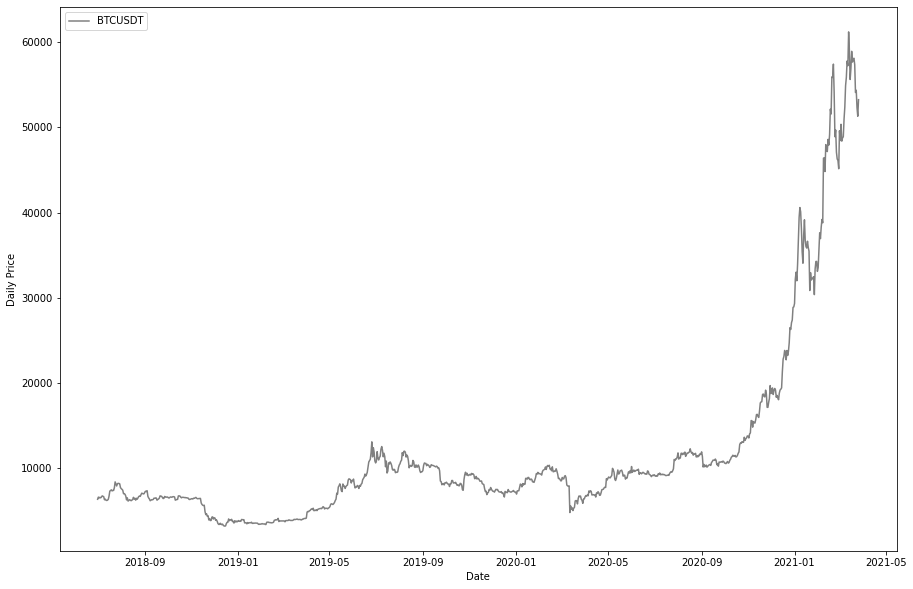

In [ ]:
import requests
import numpy as np
import datetime
from matplotlib import pyplot as plt

#SYMBOL = 'XRPUSDT'
#REQ_LIMIT = 300

SYMBOL = 'BTCUSDT'
REQ_LIMIT = 1000

trds = requests.get(f'https://api1.binance.com/api/v3/klines?symbol={SYMBOL}&interval=1d&limit={REQ_LIMIT}').json()
bar_times = []
close_prcs = []
for trd in trds:
    bar_times.append(datetime.datetime.utcfromtimestamp(int(trd[0]) * 0.001))
    close_prcs.append(float(trd[4]))

host_bar_times = np.array(bar_times, dtype=np.datetime64)
host_prcs = np.array(close_prcs, dtype=np.float64)
plt.figure(figsize=(15, 10))
plt.plot(host_bar_times, host_prcs, color='gray')
plt.xlabel('Date')
plt.ylabel('Daily Price')
plt.legend([SYMBOL], loc='upper left')
plt.show()

# 사용할 Block 개수 정하기

In [ ]:
DATA_CNT = len(host_prcs)
BLOCK_CNT = max(1, min(DATA_CNT // THD_CNT, 65535))

# SMA 계산

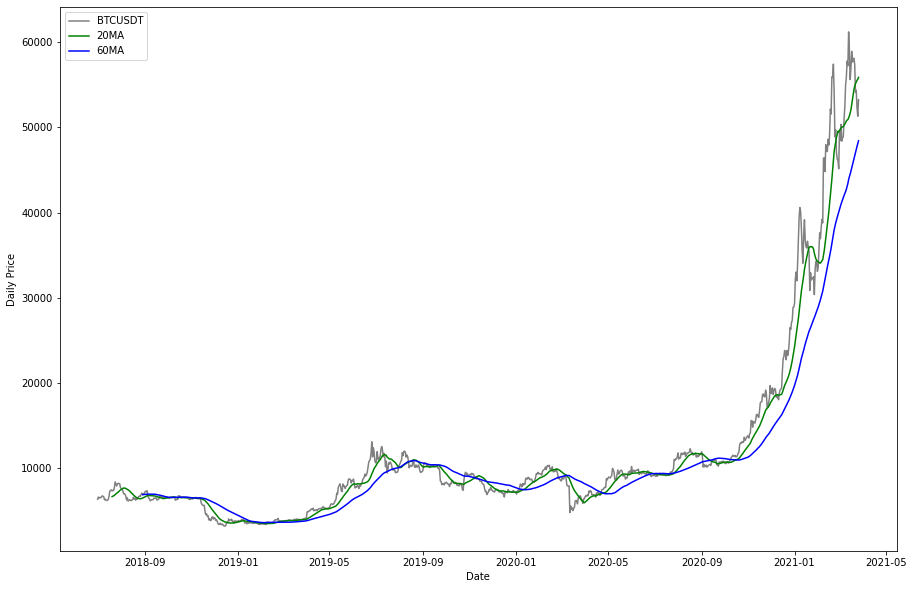

In [ ]:
import pycuda.autoinit
import pycuda.driver as drv
from pycuda.compiler import SourceModule
 
import numpy as np
 
MA_SHT_PERIOD = 20
MA_LNG_PERIOD = 60
 
kernel_code = '''
__constant__ int tot_arr_size;
 
extern "C" {
    __global__ void get_sma(double* ma, double* prc, int* period) {
        const int tid = threadIdx.x + blockIdx.x * blockDim.x;
        const int thdsCnt = blockDim.x * gridDim.x;
        int st_idx = 0;
        double sum = 0.0;
        int i = tid;
        int j = 0;
        
        while ( i < tot_arr_size ) {
          st_idx = i - (*period) + 1;
 
          if ( 0 <= st_idx ) {
            sum = 0.0;
 
            for ( j=st_idx ; j<=i ; j++ ) {
              sum += prc[j];
            }
 
            ma[i] = sum / (double)(*period);
          }
 
          i += thdsCnt;
        }
    }
}
'''
 
# Compile the kernel code
mod = SourceModule(kernel_code, keep=False, no_extern_c=True)
 
# Get kernel function
get_sma = mod.get_function('get_sma')
 
# Set Constant
tot_arr_size = mod.get_global("tot_arr_size")[0]
drv.memcpy_htod(tot_arr_size, np.int32(DATA_CNT))
 
# Device memory allocation
device_prc = drv.mem_alloc(host_prcs.nbytes)
 
# Memcpy Host to Device
drv.memcpy_htod(device_prc, host_prcs)
 
# Host memory allocation
host_sht_ma = np.zeros(DATA_CNT, dtype=np.float64)
host_lng_ma = np.zeros(DATA_CNT, dtype=np.float64)
 
# Run
get_sma(drv.InOut(host_sht_ma), device_prc, drv.In(np.int32(MA_SHT_PERIOD)), block=(THD_CNT, 1, 1), grid=(BLOCK_CNT, 1))
get_sma(drv.InOut(host_lng_ma), device_prc, drv.In(np.int32(MA_LNG_PERIOD)), block=(THD_CNT, 1, 1), grid=(BLOCK_CNT, 1))
 
# Free Memory
device_prc.free()
 
plt.figure(figsize=(15, 10))
plt.plot(host_bar_times, host_prcs, color='gray')
plt.plot(host_bar_times[MA_SHT_PERIOD-1:], host_sht_ma[MA_SHT_PERIOD-1:], color='green')
plt.plot(host_bar_times[MA_LNG_PERIOD-1:], host_lng_ma[MA_LNG_PERIOD-1:], color='blue')
plt.xlabel('Date')
plt.ylabel('Daily Price')
plt.legend([SYMBOL, f'{MA_SHT_PERIOD}MA', f'{MA_LNG_PERIOD}MA', ], loc='upper left')
plt.show()

# 포지션 잡기

* 단기 이동평균선이 장기 이동평균선보다 크다면 1, 그 외에는 0

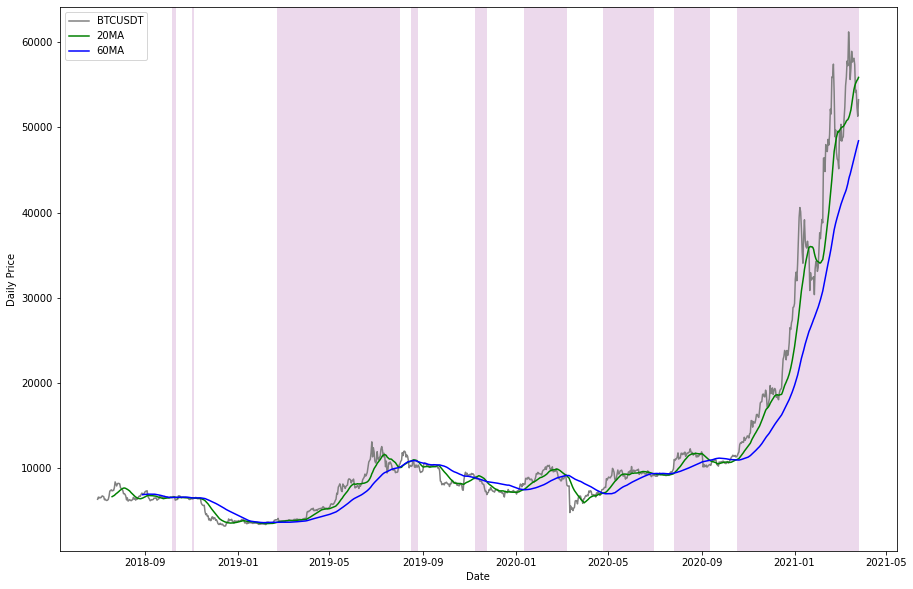

In [ ]:
import pycuda.autoinit
import pycuda.driver as drv
from pycuda.compiler import SourceModule
 
import numpy as np

kernel_code = '''
__constant__ int tot_arr_size;
 
extern "C" {
    __global__ void get_positions(int* positions, double* sht_ma, double* lng_ma) {
        const int tid = threadIdx.x + blockIdx.x * blockDim.x;
        const int thdsCnt = blockDim.x * gridDim.x;
        int i = tid;

        while ( i < tot_arr_size ) {
          if ( 0 < lng_ma[i] && lng_ma[i] < sht_ma[i] ) {
            positions[i] = 1;
          }

          i += thdsCnt;
        }
    }
}
'''

# Compile the kernel code
mod = SourceModule(kernel_code, keep=False, no_extern_c=True)
 
# Get kernel function
get_positions = mod.get_function('get_positions')

# Set Constant
tot_arr_size = mod.get_global("tot_arr_size")[0]
drv.memcpy_htod(tot_arr_size, np.int32(DATA_CNT))

# Host memory allocation
host_positions = np.zeros(DATA_CNT, dtype=np.int32)

# Run
get_positions(drv.InOut(host_positions), drv.In(host_sht_ma), drv.In(host_lng_ma), block=(THD_CNT, 1, 1), grid=(BLOCK_CNT, 1))

fig, ax1 = plt.subplots(figsize=(15, 10))
ax1.plot(host_bar_times, host_prcs, color='gray')
ax1.plot(host_bar_times[MA_SHT_PERIOD-1:], host_sht_ma[MA_SHT_PERIOD-1:], color='green')
ax1.plot(host_bar_times[MA_LNG_PERIOD-1:], host_lng_ma[MA_LNG_PERIOD-1:], color='blue')
ax1.set_xlabel('Date')
ax1.set_ylabel('Daily Price')
ax1.legend([SYMBOL, f'{MA_SHT_PERIOD}MA', f'{MA_LNG_PERIOD}MA', ], loc='upper left')

def draw_l_pos_area(ax):
    is_long_pos = False
    span_st = None
    span_ed = None

    for idx, position in enumerate(host_positions):
      if not is_long_pos and 1 == position:
        span_st = host_bar_times[idx]
        is_long_pos = True
      elif is_long_pos and 0 == position:
        span_ed = host_bar_times[idx]
        is_long_pos = False

        ax.axvspan(span_st, span_ed, facecolor='purple', alpha=0.15)

    else:
        if is_long_pos:
            span_ed = host_bar_times[idx]
            ax.axvspan(span_st, span_ed, facecolor='purple', alpha=0.15)

draw_l_pos_area(ax1)

plt.show()

# 수익률 계산

* 로그 수익률을 계산
* 포지션과 로그 수익률을 곱한다. (포지션을 보유했을 때의 수익률만 남긴다.)

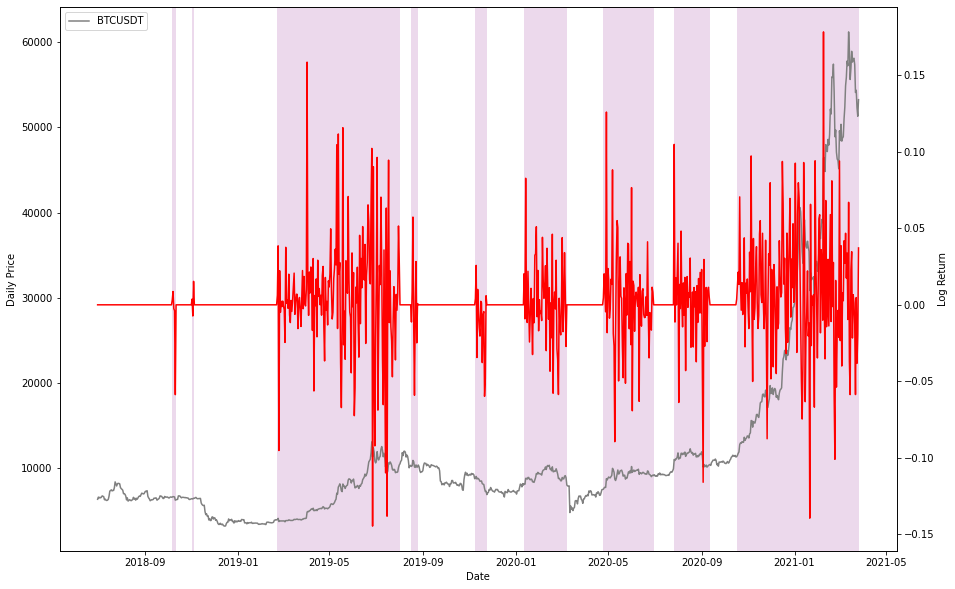

In [ ]:
import pycuda.autoinit
import pycuda.driver as drv
from pycuda.compiler import SourceModule
 
import numpy as np

kernel_code = '''
__constant__ int tot_arr_size;

extern "C" {
    __global__ void get_log_returns(double* logReturn, double* prcs) {
        const int tid = threadIdx.x + blockIdx.x * blockDim.x;
        const int totThdXCnt = blockDim.x * gridDim.x;
        int i = tid;

        while ( i < tot_arr_size ) {
          if ( 0 < i ) {
            logReturn[i] = log(prcs[i] / prcs[i-1]);
          }

          i += totThdXCnt;
        }
    }

    __global__ void product_dbl_n_int32(double* outDbl, double* inDbl, int* inint32) {
        const int tid = threadIdx.x + blockIdx.x * blockDim.x;
        const int totThdXCnt = blockDim.x * gridDim.x;
        int i = tid;

        while ( i < tot_arr_size ) {
          outDbl[i] = (0!=inint32[i]) ? inDbl[i] * (double)inint32[i] : 0.0;

          i += totThdXCnt;
        }
    }
}
'''

# Compile the kernel code
mod = SourceModule(kernel_code, keep=False, no_extern_c=True)

# Get kernel function
get_log_returns = mod.get_function('get_log_returns')
product_dbl_n_int32 = mod.get_function('product_dbl_n_int32')

# Set Constant
tot_arr_size = mod.get_global("tot_arr_size")[0]
drv.memcpy_htod(tot_arr_size, np.int32(DATA_CNT))

# Host memory allocation
host_log_returns = np.zeros(DATA_CNT, dtype=np.float64)
f_host_log_returns = np.zeros(DATA_CNT, dtype=np.float64)

# Run
get_log_returns(drv.InOut(host_log_returns), drv.In(host_prcs), block=(THD_CNT, 1, 1), grid=(BLOCK_CNT, 1))
product_dbl_n_int32(drv.InOut(f_host_log_returns), drv.In(host_log_returns), drv.In(host_positions), block=(THD_CNT, 1, 1), grid=(BLOCK_CNT, 1))

fig, ax1 = plt.subplots(figsize=(15, 10))
ax1.plot(host_bar_times, host_prcs, color='gray')
ax1.set_xlabel('Date')
ax1.set_ylabel('Daily Price')
ax1.legend([SYMBOL, f'{MA_SHT_PERIOD}MA', f'{MA_LNG_PERIOD}MA', ], loc='upper left')
draw_l_pos_area(ax1)

ax2 = ax1.twinx()
ax2.set_ylabel('Log Return')
ax2.plot(host_bar_times, f_host_log_returns, color='red')

plt.show()

# Parallel Reduction

* https://developer.download.nvidia.com/assets/cuda/files/reduction.pdf

In [ ]:
import pycuda.autoinit
import pycuda.driver as drv
from pycuda.compiler import SourceModule

import math
import numpy as np

sample_datas = np.arange(1,101, dtype=np.int32)

print(f'sample_datas: {sample_datas}')
print(f'np.sum(): {sample_datas.sum()}')

kernel_code = '''
__constant__ int tot_arr_size;

extern "C" {
    __global__ void reduction_int32(int* arr, int* i) {
        const int tid = threadIdx.x + blockIdx.x * blockDim.x;
        const int totThdXCnt = blockDim.x * gridDim.x;
        int j = 2 * tid;
        const int s = (int)pow(2, *i);

        while ( j < tot_arr_size ) {
          if ( 0 == j % (2*s) ) {
            arr[j] += arr[j+s];
          }

          j += (2 * totThdXCnt);
        }
    }
}
'''

# Compile the kernel code
mod = SourceModule(kernel_code, keep=False, no_extern_c=True)

# Get kernel function
reduction_int32 = mod.get_function('reduction_int32')

# Set Constant
tot_arr_size = mod.get_global("tot_arr_size")[0]
drv.memcpy_htod(tot_arr_size, np.int32(len(sample_datas)))

# GPU 메모리 할당
device_memory = drv.mem_alloc(sample_datas.nbytes)

# Host에서 Device로 메모리 복사
drv.memcpy_htod(device_memory, sample_datas)

# Run
i_cnt = math.ceil(math.log2(len(sample_datas)))
for i in range(i_cnt):
    reduction_int32(device_memory, drv.In(np.int32(i)), block=(THD_CNT, 1, 1), grid=(max(1, min(len(sample_datas) // 2 // THD_CNT, 65535)), 1))

# 결과값을 Device에서 Host로 메모리 복사
results = np.zeros(len(sample_datas), dtype=np.int32)
drv.memcpy_dtoh(results, device_memory)

# 메모리 해제
device_memory.free()

print(f'Reduction: {results[0]}')

sample_datas: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100]
np.sum(): 5050
Reduction: 5050


# 누적 수익률 계산

In [ ]:
import pycuda.autoinit
import pycuda.driver as drv
from pycuda.compiler import SourceModule

import math
import numpy as np

sample_datas = np.arange(1,11, dtype=np.int32)

kernel_code = '''
extern "C" {
    __global__ void reduction_dbl(double* arr, int* i, int* arr_size) {
        const int tid = threadIdx.x + blockIdx.x * blockDim.x;
        const int totThdXCnt = blockDim.x * gridDim.x;
        int j = 2 * tid;
        const int s = (int)pow(2, *i);

        while ( j < (int)(*arr_size) ) {
          if ( 0 == j % (2*s) ) {
            arr[j] += arr[j+s];
          }

          j += (2 * totThdXCnt);
        }
    }
}
'''

# Compile the kernel code
mod = SourceModule(kernel_code, keep=False, no_extern_c=True)

# Get kernel function
reduction_dbl = mod.get_function('reduction_dbl')

def get_reduction_dbl(datas):
    data_len = len(datas)

    # GPU 메모리 할당
    device_memory = drv.mem_alloc(datas.nbytes)

    # Host에서 Device로 메모리 복사
    drv.memcpy_htod(device_memory, datas)

    i_cnt = math.ceil(math.log2(data_len))
    for i in range(i_cnt):
        reduction_dbl(device_memory, drv.In(np.int32(i)), drv.In(np.int32(data_len)), block=(THD_CNT, 1, 1), grid=(max(1, min(data_len // 2 // THD_CNT, 65535)), 1))

    # 결과값을 Device에서 Host로 메모리 복사
    results = np.zeros(data_len, dtype=np.float64)
    drv.memcpy_dtoh(results, device_memory)

    # 메모리 해제
    device_memory.free()

    return results[0]

print(f'np.sum(): {f_host_log_returns.sum()}')
print(f'Reduction: {get_reduction_dbl(f_host_log_returns)}')

np.sum(): 2.625332661951583
Reduction: 2.625332661951583


# Parallel Prefix Sum (Scan)

* https://en.wikipedia.org/wiki/Prefix_sum#Parallel_algorithms

In [ ]:
import pycuda.autoinit
import pycuda.driver as drv
from pycuda.compiler import SourceModule

import math
import numpy as np

sample_datas = np.arange(1,11, dtype=np.int32)

print(f'sample_datas:\n{sample_datas}')
print(f'np.cumsum():\n{sample_datas.cumsum()}')

kernel_code = '''
extern "C" {
    __global__ void get_int32_prefix_sum(int* outX, int* inX, int* i, int* tot_arr_size) {
        const int tid = threadIdx.x + blockIdx.x * blockDim.x;
        const int totThdXCnt = blockDim.x * gridDim.x;
        int j = tid;
        int pow2i = 0;

        while ( j < *tot_arr_size ) {
          pow2i = (int)pow(2, *i);

          if ( j < pow2i ) {
            outX[j] = inX[j];
          }
          else {
            outX[j] = inX[j] + inX[j - pow2i];
          }

          j += totThdXCnt;
        }
    }
}
'''

# Compile the kernel code
mod = SourceModule(kernel_code, keep=False, no_extern_c=True)

# Get kernel function
get_int32_prefix_sum = mod.get_function('get_int32_prefix_sum')

# GPU 메모리 할당
device_memory1 = drv.mem_alloc(sample_datas.nbytes)
device_memory2 = drv.mem_alloc(sample_datas.nbytes)

# Host에서 Device로 메모리 복사
drv.memcpy_htod(device_memory1, sample_datas)

# Run
i_cnt = math.ceil(math.log2(len(sample_datas)))
input_flag = True

for i in range(i_cnt):
    if input_flag:
        get_int32_prefix_sum(device_memory2, device_memory1, drv.In(np.int32(i)), drv.In(np.int32(len(sample_datas))), block=(THD_CNT, 1, 1), grid=(max(1, min(len(sample_datas) // THD_CNT, 65535)), 1))
    else:
        get_int32_prefix_sum(device_memory1, device_memory2, drv.In(np.int32(i)), drv.In(np.int32(len(sample_datas))), block=(THD_CNT, 1, 1), grid=(max(1, min(len(sample_datas) // THD_CNT, 65535)), 1))

    input_flag = not input_flag

# 결과값을 Device에서 Host로 메모리 복사
results = np.zeros(len(sample_datas), dtype=np.int32)

if input_flag:
    drv.memcpy_dtoh(results, device_memory1)
else:
    drv.memcpy_dtoh(results, device_memory2)

# 메모리 해제
device_memory1.free()
device_memory2.free()

print(f'Parallel prefix sum:\n{results}')

sample_datas:
[ 1  2  3  4  5  6  7  8  9 10]
np.cumsum():
[ 1  3  6 10 15 21 28 36 45 55]
Parallel prefix sum:
[ 1  3  6 10 15 21 28 36 45 55]


# 누적 수익률 그래프

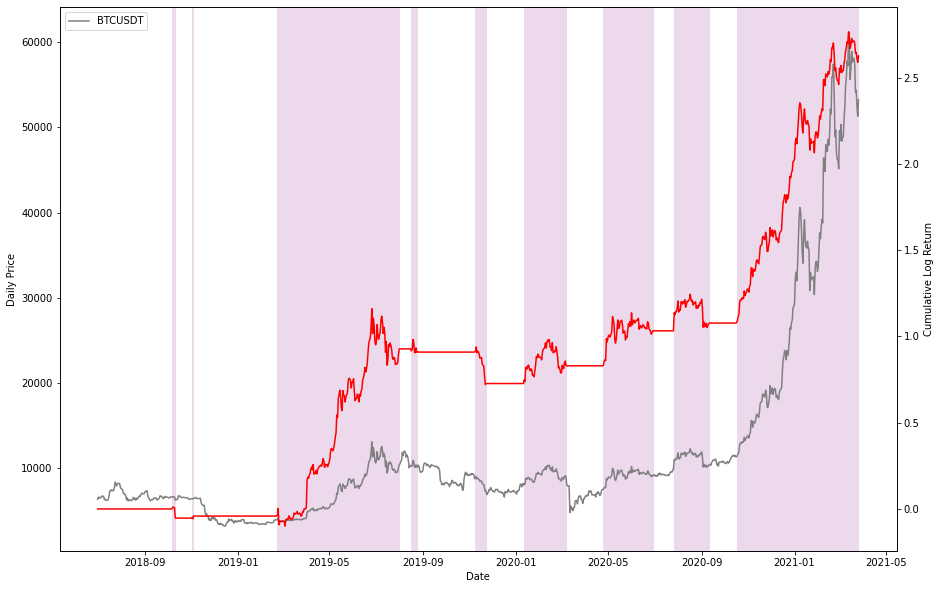

In [ ]:
import pycuda.autoinit
import pycuda.driver as drv
from pycuda.compiler import SourceModule

import math
import numpy as np

kernel_code = '''
extern "C" {
    __global__ void dbl_prefix_sum(double* outX, double* inX, int* i, int* arr_size) {
        const int tid = threadIdx.x + blockIdx.x * blockDim.x;
        const int totThdXCnt = blockDim.x * gridDim.x;
        int j = tid;
        int pow2i = 0;

        while ( j < *arr_size ) {
          pow2i = (int)pow(2, *i);

          if ( j < pow2i ) {
            outX[j] = inX[j];
          }
          else {
            outX[j] = inX[j] + inX[j - pow2i];
          }

          j += totThdXCnt;
        }
    }
}
'''

# Compile the kernel code
mod = SourceModule(kernel_code, keep=False, no_extern_c=True)

# Get kernel function
dbl_prefix_sum = mod.get_function('dbl_prefix_sum')

def get_dbl_prefix_sum(datas):
    data_len = len(datas)

    # GPU 메모리 할당
    device_memory1 = drv.mem_alloc(datas.nbytes)
    device_memory2 = drv.mem_alloc(datas.nbytes)

    # Host에서 Device로 메모리 복사
    drv.memcpy_htod(device_memory1, datas)

    # Run
    i_cnt = math.ceil(math.log2(data_len))
    input_flag = True

    for i in range(i_cnt):
        if input_flag:
            dbl_prefix_sum(device_memory2, device_memory1, drv.In(np.int32(i)), drv.In(np.int32(data_len)), block=(THD_CNT, 1, 1), grid=(max(1, min(data_len // THD_CNT, 65535)), 1))
        else:
            dbl_prefix_sum(device_memory1, device_memory2, drv.In(np.int32(i)), drv.In(np.int32(data_len)), block=(THD_CNT, 1, 1), grid=(max(1, min(data_len // THD_CNT, 65535)), 1))

        input_flag = not input_flag

    # 결과값을 Device에서 Host로 메모리 복사
    results = np.zeros(data_len, dtype=np.float64)

    if input_flag:
        drv.memcpy_dtoh(results, device_memory1)
    else:
        drv.memcpy_dtoh(results, device_memory2)

    # 메모리 해제
    device_memory1.free()
    device_memory2.free()

    return results

cum_log_returns = get_dbl_prefix_sum(f_host_log_returns)

fig, ax1 = plt.subplots(figsize=(15, 10))
ax1.plot(host_bar_times, host_prcs, color='gray')
ax1.set_xlabel('Date')
ax1.set_ylabel('Daily Price')
ax1.legend([SYMBOL, f'{MA_SHT_PERIOD}MA', f'{MA_LNG_PERIOD}MA', ], loc='upper left')
draw_l_pos_area(ax1)

ax2 = ax1.twinx()
ax2.set_ylabel('Cumulative Log Return')
ax2.plot(host_bar_times, cum_log_returns, color='red')

plt.show()

# 개선된 SMA

* Parallel Prefix Sum를 이용하여 단순 이동평균선을 더 효율적으로 계산할 수 있다.

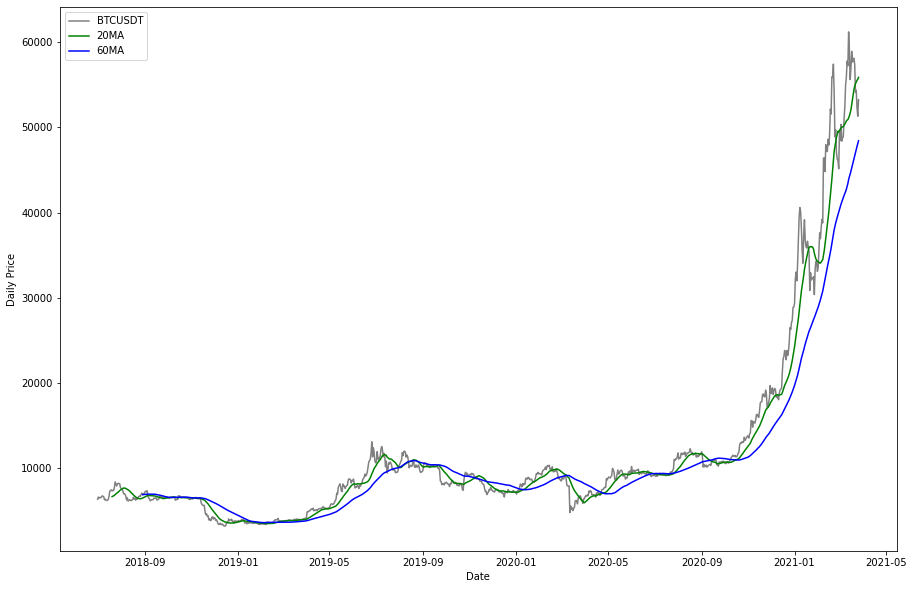

In [ ]:
import pycuda.autoinit
import pycuda.driver as drv
from pycuda.compiler import SourceModule

import numpy as np

kernel_code = '''
extern "C" {
    __global__ void get_sma2(double* outMa, double* inCumSumPrc, int* period, int* arr_size) {
        const int tid = threadIdx.x + blockIdx.x * blockDim.x;
        const int totThdXCnt = blockDim.x * gridDim.x;
        int i = tid;
        int st_idx = 0;

        while ( i < *arr_size ) {
          st_idx = i - (*period);

          if ( 0 <= st_idx ) {
            outMa[i] = (inCumSumPrc[i] - inCumSumPrc[st_idx]) / (double)(*period);
          }
          else if ( -1 == st_idx ) {
            outMa[i] = inCumSumPrc[i] / (double)(*period);
          }

          i += totThdXCnt;
        }
    }
}
'''

# Compile the kernel code
mod = SourceModule(kernel_code, keep=False, no_extern_c=True)

# Get kernel function
get_sma2 = mod.get_function('get_sma2')

# Host memory allocation
host_sht_ma2 = np.zeros(DATA_CNT, dtype=np.float64)
host_lng_ma2 = np.zeros(DATA_CNT, dtype=np.float64)

# Run
prefix_sum_prcs = get_dbl_prefix_sum(host_prcs)
get_sma2(drv.InOut(host_sht_ma2), drv.In(prefix_sum_prcs), drv.In(np.int32(MA_SHT_PERIOD)), drv.In(np.int32(DATA_CNT)), block=(THD_CNT, 1, 1), grid=(BLOCK_CNT, 1))
get_sma2(drv.InOut(host_lng_ma2), drv.In(prefix_sum_prcs), drv.In(np.int32(MA_LNG_PERIOD)), drv.In(np.int32(DATA_CNT)), block=(THD_CNT, 1, 1), grid=(BLOCK_CNT, 1))

plt.figure(figsize=(15, 10))
plt.plot(host_bar_times, host_prcs, color='gray')
plt.plot(host_bar_times[MA_SHT_PERIOD-1:], host_sht_ma2[MA_SHT_PERIOD-1:], color='green')
plt.plot(host_bar_times[MA_LNG_PERIOD-1:], host_lng_ma2[MA_LNG_PERIOD-1:], color='blue')
plt.xlabel('Date')
plt.ylabel('Daily Price')
plt.legend([SYMBOL, f'{MA_SHT_PERIOD}MA', f'{MA_LNG_PERIOD}MA', ], loc='upper left')
plt.show()

* 기존에 계산한 값과 동일한지 체크



In [ ]:
print(f'Short Ma: {np.allclose(host_sht_ma, host_sht_ma2, atol=1e-08)}')
print(f'Long Ma: {np.allclose(host_lng_ma, host_lng_ma2, atol=1e-08)}')

Short Ma: True
Long Ma: True
